# 1 Load data and Api

In [1]:
from  utils.coco_text import  coco_text
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

%load_ext autoreload
%autoreload 2

ct = coco_text.COCO_Text('data/COCO_Text.json')
ct.info()

loading annotations into memory...
0:00:05.093946
creating index...
index created!
url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


### Example

{'width': 640, 'file_name': 'COCO_train2014_000000498601.jpg', 'set': 'val', 'id': 498601, 'height': 427}
[{'polygon': [192.89893913269043, 219.93053245544434, 237.87370491027832, 219.93053245544434, 237.87370491027832, 249.9038486480713, 192.89893913269043, 249.9038486480713], 'language': 'english', 'area': 1348.0428753409797, 'id': 1148291, 'utf8_string': 'N23FK', 'image_id': 498601, 'bbox': [192.89893913269043, 219.93053245544434, 44.97476577758789, 29.973316192626953], 'legibility': 'legible', 'class': 'machine printed'}]


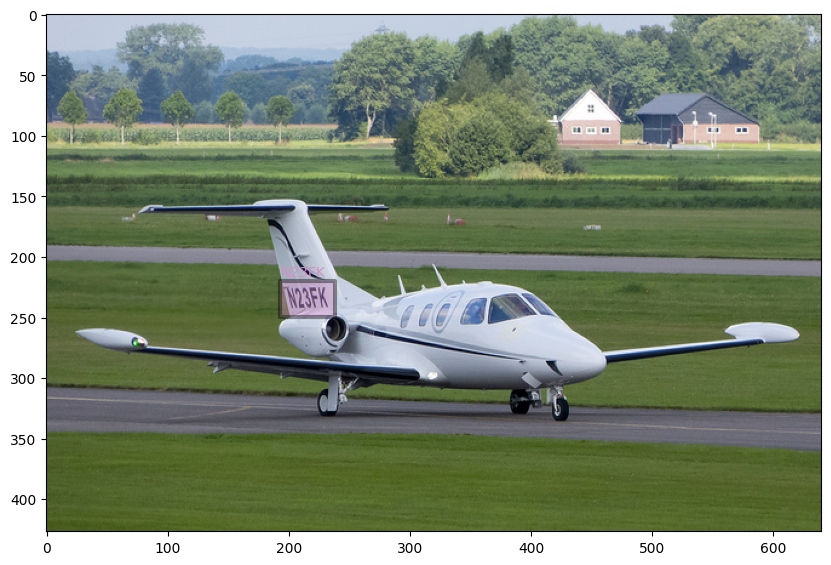

In [2]:
dataDir = "/home/andrzej/PycharmProjects/OCR/data"
dataType='train2014'

imgIds = ct.getImgIds(imgIds=ct.train,
                    # catIds=[('legibility','legible')
                              catIds=[('legibility','legible'),('class','handwritten')
                            ]
                      )
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# img = ct.loadImgs(162700)[0] # handwritten

img = ct.loadImgs(498601)[0]
print(img)

img_path = '%s/%s/%s'%(dataDir,dataType,img['file_name'])
I = io.imread(img_path)
plt.imshow(I)
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
print(anns)
ct.showAnns(anns)

# Test EAST and CRAFT

In [6]:
from PIL import Image

def get_image_text_from_image(image,bbox):
    return image[ bbox[1]:bbox[1] + bbox[3],bbox[0]:bbox[0]+bbox[2],:]

def plot_image(image):
    plt.imshow(image)
    Image.fromarray(np.uint8(image))

EAST

(427, 640, 3)
(198, 217) (228, 245)
[198, 217, 30, 28]


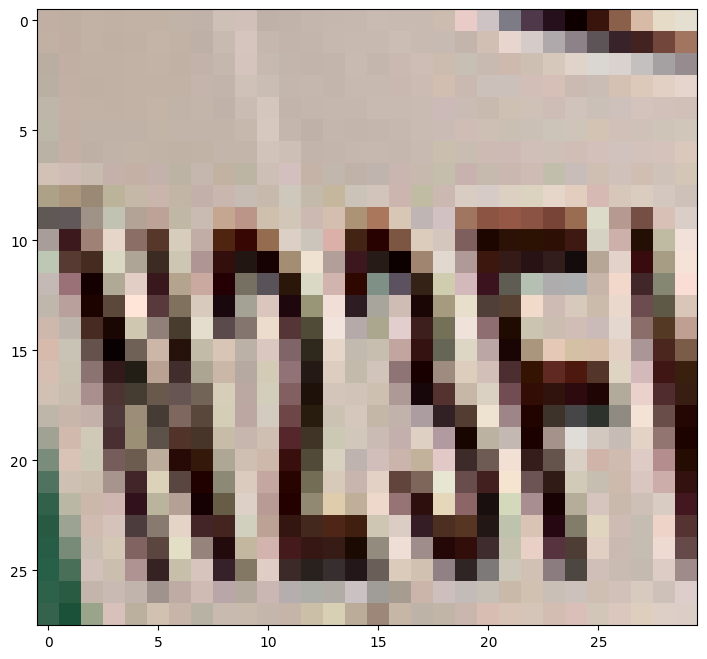

In [4]:
from utils.detect.east import  east_detect
from utils.filters import median_filtering, bilateral_filtering, to_threshold_binary
import cv2

image_org = cv2.imread(img_path)
image = image_org.copy()
bboxes = east_detect(image)

bbox = bboxes[0]
image_text = get_image_text_from_image(image,bbox)
print(bbox)
plot_image(image_text)

Craft

/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading weights from checkpoint (saved_models/craft_mlt_25k.pth)
elapsed time : 2.2464661598205566s


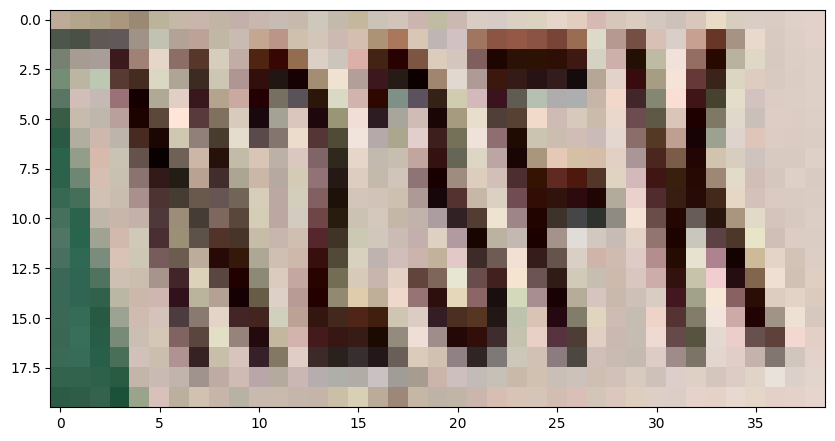

In [5]:
from utils.detect.craft_main import craft_main

image = image_org.copy()
bboxes = craft_main(image)

bbox = bboxes[0]
image_text =get_image_text_from_image(image_org,bbox)
plot_image(image_text)

Wnioski:
- EAST jest szybszy algorytmem niż CRAFT.
- CRAFT lepiej  zlokalizował text, EAST obciął ostatnią literę.
- Dodanie filtrów oraz próby na innych przykładach wykazały, że CRAFT lepiej lokalizuje

# Add fitr to CRAFT

Median

3


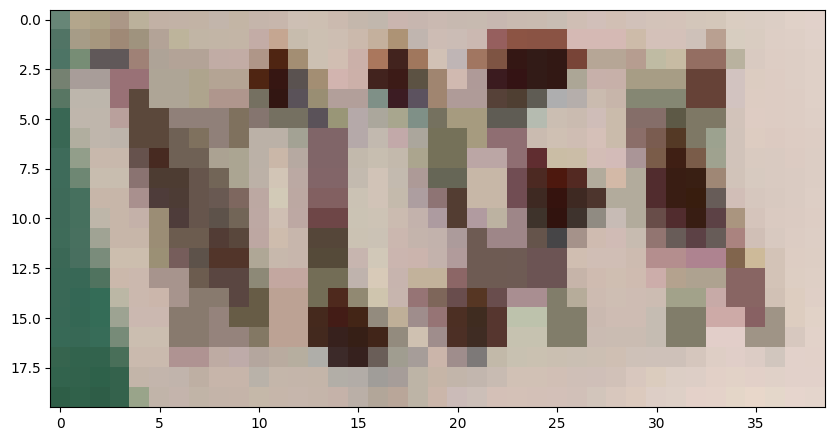

In [6]:
image  = image_org.copy()

image = median_filtering(image,3)
# bboxes = craft_main(image)
# bbox = bboxes[0]
image_text =get_image_text_from_image(image,bbox)
plot_image(image_text)

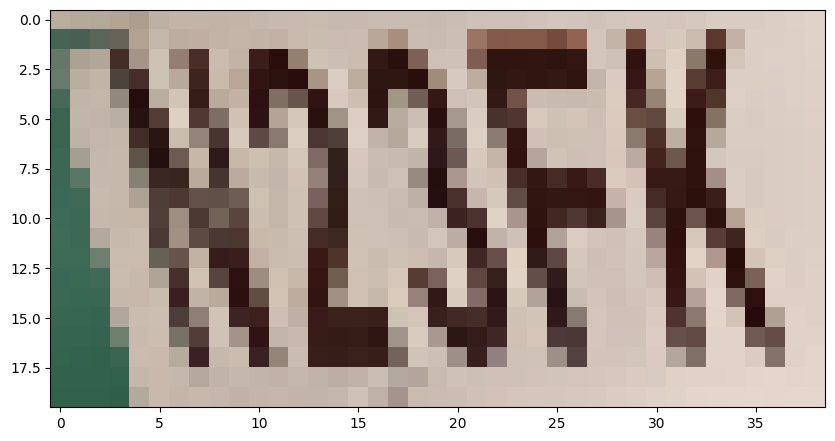

In [7]:
image  = image_org.copy()

image = cv2.bilateralFilter(image, 9, 75, 75)
# bboxes = craft_main(image)
bbox = bboxes[0]
image_text =get_image_text_from_image(image,bbox)
# image_text =get_image_text_from_image(image_org)
plot_image(image_text)


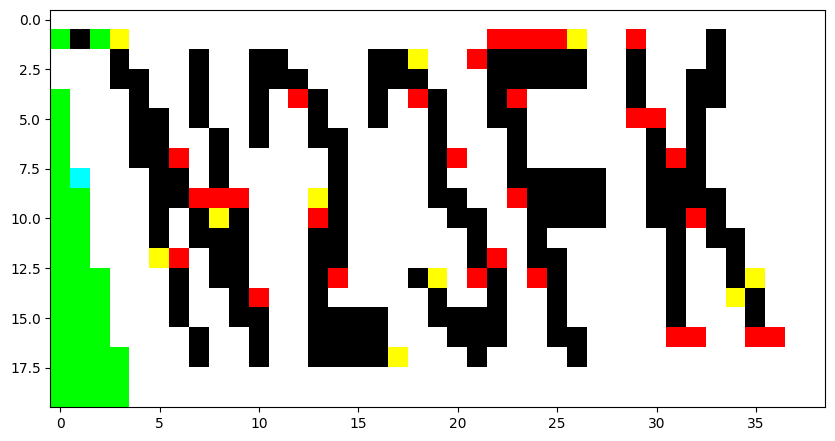

In [8]:
import numpy as np
import cv2
image = image_text.copy()
norm_img = np.zeros((image.shape[0], image.shape[1]))
image = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)[1]
image = cv2.GaussianBlur(image, (1, 1), 0)
# image_text =get_image_text_from_image(image,bbox)
# image_text =get_image_text_from_image(image_org)
plot_image(image)

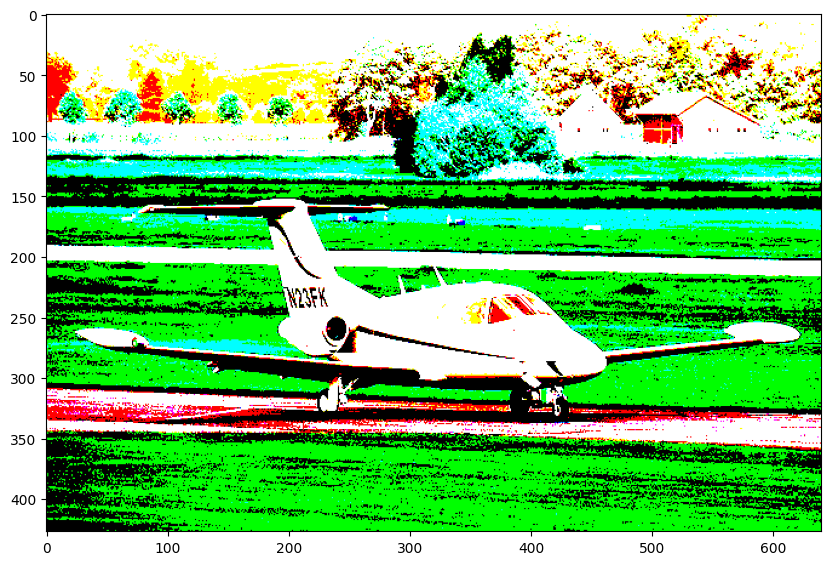

In [7]:
import cv2
image_org = cv2.imread(img_path)
img = image_org.copy()
norm_img = np.zeros((img.shape[0], img.shape[1]))
img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)[1]
img = cv2.GaussianBlur(img, (1, 1), 0)
# image_text =get_image_text_from_image(image,bbox)
# image_text =get_image_text_from_image(image_org)
plot_image(img)

In [9]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
def read_text_from_image(image_text,pretrain_model = "microsoft/trocr-base-printed"):
    # microsoft/trocr-base-printed
    # microsoft/trocr-base-handwritten

    processor = TrOCRProcessor.from_pretrained(pretrain_model)

    model = VisionEncoderDecoderModel.from_pretrained(pretrain_model)

    pixel_values = processor(image_text, return_tensors="pt").pixel_values
    #
    generated_ids = model.generate(pixel_values)
    #
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return  generated_text
generated_text = read_text_from_image(image_text)
generated_text

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` v

'W23FK'

# Save result

In [63]:
import  json
json_out = {}
json_out["utf8_string"] = generated_text
json_out["image_id"] =img["id"]
json_out["bbox"] =  list(bbox.astype(float))
# json_out
# json_out

json_out = [json_out]
with open('our_results_test.json', 'w') as f:
    json.dump(json_out,f)


# 3 Evaluation API

In [65]:
from utils.coco_text import coco_evaluation
our_results = ct.loadRes('our_results_test.json')
list(our_results.imgs.keys())


Loading and preparing results...     
DONE (t=0.01s)


[498601]


### Detection results

In [66]:
our_detections = coco_evaluation.getDetections(ct, our_results,imgIds=list(our_results.imgs.keys()), detection_threshold =0.5)
# our_detections
print('True positives have a ground truth id and an evaluation id: ', our_detections['true_positives'][0])
print('False positives only have an evaluation id: ', our_detections['false_positives'][0] if len(our_detections['false_positives']) > 1 else [])
print('True negatives only have a ground truth id: ', our_detections['false_negatives'][0] if len(our_detections['false_negatives']) > 1 else [])

True positives have a ground truth id and an evaluation id:  {'gt_id': 1148291, 'eval_id': 0}
False positives only have an evaluation id:  []
True negatives only have a ground truth id:  []


### End-to-end results

In [67]:
our_endToEnd_results = coco_evaluation.evaluateEndToEnd(ct, our_results,imgIds=list(our_results.imgs.keys()), detection_threshold = 0.5)
coco_evaluation.printDetailedResults(ct,our_detections,our_endToEnd_results,'our approach')


our approach

Detection
Recall
legible & machine printed:  100.00
legible & handwritten:  0
legible overall:  100.00
illegible & machine printed:  0
illegible & handwritten:  0
illegible overall:  0
total recall:  100.0
Precision
total precision:  100.00
f-score
f-score localization:  100.00

Transcription
accuracy for exact matches:  0.00
accuracy for matches with edit distance<=1:  100.00

End-to-end
recall:  0.00 precision:  0.00
End-to-end f-score:  0

100.00 & 0 & 0 & 0 & 100.0 & 100.00 & 100.00 & 0.00 & 0.00 & 0.00 & 0


In [5]:
from PIL import Image

import pytesseract


# Simple image to string
#
print(pytesseract.image_to_string(Image.fromarray(image_text))


SyntaxError: unexpected EOF while parsing (1622124340.py, line 8)